In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
import os;
os.listdir('/home/')

['test.csv', 'train.csv', 'movies.csv']

In [ ]:
ratings = pd.read_csv("/home/train.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [ ]:
movies = pd.read_csv("/home/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
test = pd.read_csv("/home/test.csv")
test.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [ ]:
# Combining title and genres into a single string
movies['combined_features'] = movies['genres'] + ' ' + movies['title']
movies['combined_features'].head()

0    Adventure|Animation|Children|Comedy|Fantasy To...
1            Adventure|Children|Fantasy Jumanji (1995)
2               Comedy|Romance Grumpier Old Men (1995)
3        Comedy|Drama|Romance Waiting to Exhale (1995)
4            Comedy Father of the Bride Part II (1995)
Name: combined_features, dtype: object

In [ ]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 10040170
Number of unique movieId's: 48213
Number of unique users: 162541
Average number of ratings per user: 61.77
Average number of ratings per movie: 208.25


<ipython-input-9-1574b7711e73>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=ratings, palette="viridis")


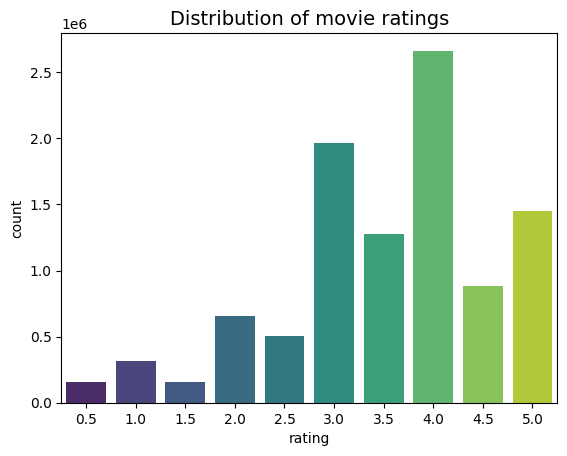

In [ ]:
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [ ]:
mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean rating per user: 3.68.


In [ ]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:15]

title
Shawshank Redemption, The (1994)                             32961
Forrest Gump (1994)                                          32500
Pulp Fiction (1994)                                          31814
Silence of the Lambs, The (1991)                             29566
Matrix, The (1999)                                           29135
Star Wars: Episode IV - A New Hope (1977)                    27658
Jurassic Park (1993)                                         25604
Schindler's List (1993)                                      24111
Braveheart (1995)                                            23815
Fight Club (1999)                                            23621
Terminator 2: Judgment Day (1991)                            23161
Toy Story (1995)                                             23145
Star Wars: Episode V - The Empire Strikes Back (1980)        23048
Lord of the Rings: The Fellowship of the Ring, The (2001)    22313
Usual Suspects, The (1995)                              

In [ ]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId']==lowest_rated]

,movieId,title,genres,combined_features
5645,5757,History of Kim Skov (Historien om Kim Skov) (1...,Documentary|Drama,Documentary|Drama History of Kim Skov (Histori...


In [ ]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres,combined_features
3141,3234,Train Ride to Hollywood (1975),Comedy|Fantasy|Musical,Comedy|Fantasy|Musical Train Ride to Hollywood...


In [ ]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
3913468,124635,3234,5.0,1047315411


In [ ]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.head()

,count,mean
movieId,,
1,23145,3.889911
2,9711,3.261868
3,4743,3.131984
4,971,2.877961
5,4672,3.057577


In [ ]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 208.25
Average rating for a given movie: 3.10


In [ ]:
lamerica = pd.Series([5, 5])
bayesian_avg(lamerica)

3.118

In [ ]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [ ]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head(10)

,movieId,count,mean,bayesian_avg,title
314,318,32961,4.417418,4.409,"Shawshank Redemption, The (1994)"
840,858,21034,4.311353,4.299,"Godfather, The (1972)"
49,50,22124,4.277956,4.267,"Usual Suspects, The (1995)"
1190,1221,13576,4.274050,4.256,"Godfather: Part II, The (1974)"
522,527,24111,4.248185,4.238,Schindler's List (1993)
1929,2019,5487,4.261892,4.219,Seven Samurai (Shichinin no samurai) (1954)
1173,1203,6617,4.252758,4.218,12 Angry Men (1957)
2866,2959,23621,4.228144,4.218,Fight Club (1999)
883,904,8189,4.242154,4.214,Rear Window (1954)
1164,1193,14461,4.217378,4.202,One Flew Over the Cuckoo's Nest (1975)


In [ ]:
movie_stats.sort_values('bayesian_avg', ascending=True).head(10)

,movieId,count,mean,bayesian_avg,title
3493,3593,1714,1.574679,1.740,Battlefield Earth (2000)
11310,50798,484,1.471074,1.961,Epic Movie (2007)
6457,6587,307,1.200326,1.968,Gigli (2003)
1501,1556,2136,1.908240,2.014,Speed 2: Cruise Control (1997)
1688,1760,1041,1.797310,2.015,Spice World (1997)
4668,4775,279,1.209677,2.018,Glitter (2001)
6354,6482,784,1.745536,2.030,Dumb and Dumberer: When Harry Met Lloyd (2003)
7945,8666,923,1.810943,2.048,Catwoman (2004)
1643,1707,1213,1.871805,2.052,Home Alone 3 (1997)
12561,61348,248,1.179435,2.056,Disaster Movie (2008)


In [ ]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres,combined_features
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",Adventure|Animation|Children|Comedy|Fantasy To...
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",Adventure|Children|Fantasy Jumanji (1995)
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",Comedy|Romance Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",Comedy|Drama|Romance Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995),[Comedy],Comedy Father of the Bride Part II (1995)


In [ ]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Adventure': 4145,
         'Animation': 2929,
         'Children': 2935,
         'Comedy': 16870,
         'Fantasy': 2731,
         'Romance': 7719,
         'Drama': 25606,
         'Action': 7348,
         'Crime': 5319,
         'Thriller': 8654,
         'Horror': 5989,
         'Mystery': 2925,
         'Sci-Fi': 3595,
         'IMAX': 195,
         'Documentary': 5605,
         'War': 1874,
         'Musical': 1054,
         'Western': 1399,
         'Film-Noir': 353,
         '(no genres listed)': 5062})

In [ ]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 25606), ('Comedy', 16870), ('Thriller', 8654), ('Romance', 7719), ('Action', 7348)]


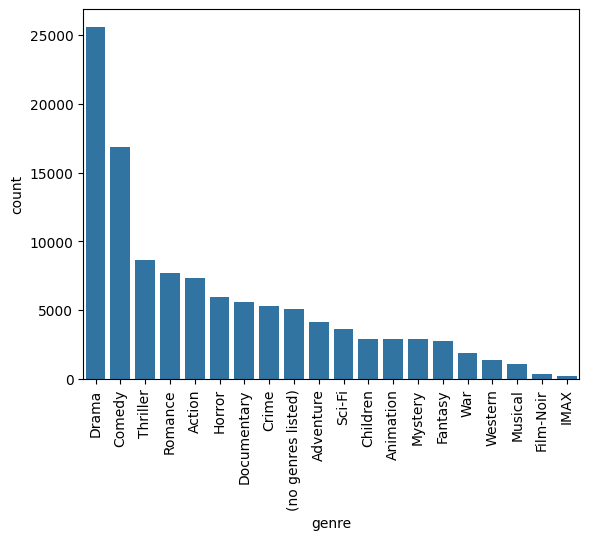

In [ ]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()

In [ ]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.

    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [ ]:
X.shape

(162541, 48213)

In [ ]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 0.13%


In [ ]:
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

162541

In [ ]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 12952 movies.
Least active user rated 1 movies.


<ipython-input-31-44089890dcd7>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_user, shade=True)


NameError: name 'n_ratings_per_movie' is not defined

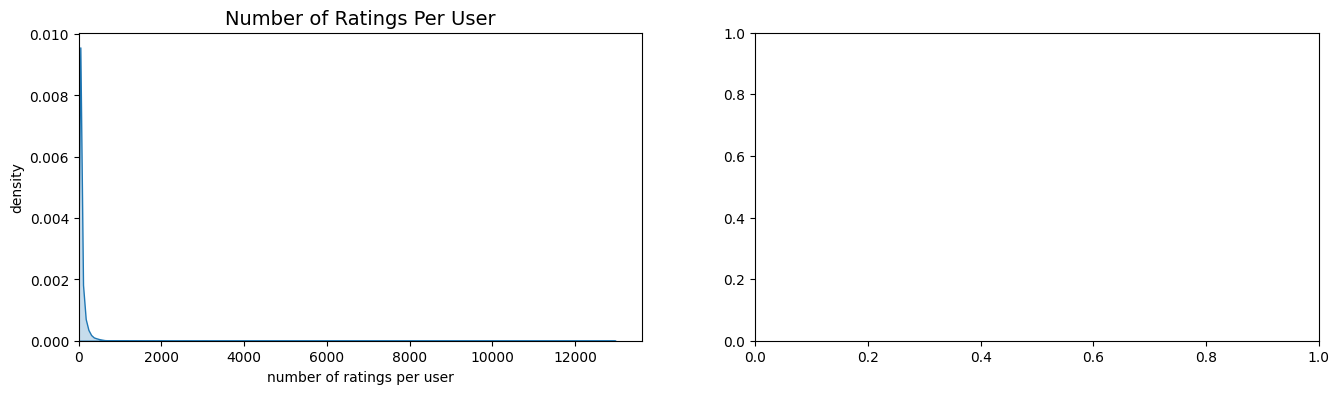

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)


def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.

    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations

    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []

    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [ ]:
similar_movies = find_similar_movies(1, X_imputed, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[260, 3114, 356, 1270, 588, 480, 1210, 780, 364]

In [ ]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_movies = find_similar_movies(movie_id, X_imputed, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Star Wars: Episode IV - A New Hope (1977)
Toy Story 2 (1999)
Forrest Gump (1994)
Back to the Future (1985)
Aladdin (1992)
Jurassic Park (1993)
Star Wars: Episode VI - Return of the Jedi (1983)
Independence Day (a.k.a. ID4) (1996)
Lion King, The (1994)


In [ ]:
movie_id = 1

similar_movies = find_similar_movies(movie_id, X_imputed, movie_mapper, movie_inv_mapper, metric='euclidean', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Gigli (2003)
Kicking & Screaming (2005)
Son of the Mask (2005)
Turbo: A Power Rangers Movie (1997)
Planes (2013)
Piglet's Big Movie (2003)
Beverly Hills Chihuahua (2008)
Arthur 2: On the Rocks (1988)
Splitting Heirs (1993)


In [ ]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 62423 unique movies in our movies dataset.


In [ ]:
genres = set(g for G in movies['genres'] for g in G)

for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))

movie_genres = movies.drop(columns=['movieId', 'title','genres'])

In [ ]:
movie_genres.head()

,combined_features,War,Animation,Sci-Fi,Horror,Crime,Drama,(no genres listed),Film-Noir,Musical,...,Adventure,IMAX,Thriller,Fantasy,Action,Documentary,Comedy,Romance,Mystery,Western
0,Adventure|Animation|Children|Comedy|Fantasy To...,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
1,Adventure|Children|Fantasy Jumanji (1995),0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,Comedy|Romance Grumpier Old Men (1995),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,Comedy|Drama|Romance Waiting to Exhale (1995),0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,Comedy Father of the Bride Part II (1995),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
# Vectorize the combined features using TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['combined_features'])
tfidf_matrix_500 = tfidf_matrix[:500, :]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix_500, tfidf_matrix_500)

print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (500, 500)


In [ ]:
!pip install fuzzywuzzy

In [ ]:
!pip install python-Levenshtein

from fuzzywuzzy import process


In [ ]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

In [ ]:
title = movie_finder('juminji')
title

'Jumanji (1995)'

In [ ]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
print(f"Movie index for Jumanji: {idx}")

Movie index for Jumanji: 1


In [ ]:
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]

In [ ]:
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Jumanji (1995):


26                         Now and Then (1995)
0                             Toy Story (1995)
190                            The Show (1995)
156                              Casper (1995)
59          Indian in the Cupboard, The (1995)
240                               Gordy (1995)
144        Amazing Panda Adventure, The (1995)
55              Kids of the Round Table (1995)
12                                Balto (1995)
167    Free Willy 2: The Adventure Home (1995)
Name: title, dtype: object

In [ ]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Because you watched {title}:")
    print(movies['title'].iloc[similar_movies])

In [ ]:
get_content_based_recommendations('toy story', 5)

Because you watched Toy Story (1995):
26                   Now and Then (1995)
1                         Jumanji (1995)
12                          Balto (1995)
240                         Gordy (1995)
124    NeverEnding Story III, The (1994)
Name: title, dtype: object


In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, n_iter=10)
Q = svd.fit_transform(X.T)
Q.shape

(48213, 20)

In [ ]:
movie_id = 1
similar_movies = find_similar_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Willy Wonka & the Chocolate Factory (1971)
Independence Day (a.k.a. ID4) (1996)
Mission: Impossible (1996)
Hunchback of Notre Dame, The (1996)
James and the Giant Peach (1996)
Toy Story 2 (1999)
Nutty Professor, The (1996)
Twister (1996)
101 Dalmatians (1996)


In [ ]:
# Evaluation and Submission Preparation

from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

# Predict ratings for the test set
def predict_ratings(user_id, movie_id, X_imputed, user_mapper, movie_mapper):
    if user_id in user_mapper and movie_id in movie_mapper:
        user_index = user_mapper[user_id]
        movie_index = movie_mapper[movie_id]
        return X[user_index, movie_index]
    else:
        return np.nan

# Generate predictions
test['predicted_rating'] = test.apply(lambda row: predict_ratings(row['userId'], row['movieId'], X_imputed, user_mapper, movie_mapper), axis=1)
# Handle cold-start problem by filling NaNs with global average rating
global_avg_rating = ratings['rating'].mean()
test['predicted_rating'].fillna(global_avg_rating, inplace=True)

# Ensure the predictions are within the valid range
test['predicted_rating'] = test['predicted_rating'].clip(1.0, 5.0)

# Prepare submission file
test['Id'] = test['userId'].astype(str) + '_' + test['movieId'].astype(str)
submission = test[['Id', 'predicted_rating']].rename(columns={'predicted_rating': 'rating'})
submission.to_csv('submissionone.csv', index=False)

print("Submission file created successfully!")


Submission file created successfully!


In [ ]:
pd.read_csv('submissionone.csv')

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0
...,...,...
5000014,162541_4079,1.0
5000015,162541_4467,1.0
5000016,162541_4980,1.0
5000017,162541_5689,1.0
